In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from pprint import pprint

In [2]:
#load weather data
from weather_collection import WeatherDatum
weather = pickle.load(open('LargeDataStorage/weatherDataFile', 'rb'))

#load hubway data
hubway = pickle.load(open('LargeDataStorage/hubwayDataFile', 'rb'))

In [3]:
def count_riders(year, month, day, hour):
	"""
	Input: year, month, day, hour
	Output: total riders during that hour
	"""

	#initialize counter
	counter = 0

	#counts riders during a given hour
	for minute in range(0,60):
		#-1 means that there is no data for that time, so we don't count that
		if hubway.data[year][month][day+1][hour][minute] == -1:
			pass
		else:
			counter += len(hubway.data[year][month][day+1][hour][minute])
	return counter

In [4]:
def process_data(year):
    """
    Returns 2 lists, 1 of temperatures, 1 of associated ridership.
    """

    #determines whether or not it is a leap year
    if year % 4 == 0:
        numDaysInMonth = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    else:
        numDaysInMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    riders_vs_temp = {}

    #adds all hourly temperatures in given year to dictionary as keys with values of 0
    for m in range(1,13):
        for d in range(numDaysInMonth[m-1]):
            for h in range(0,24):
                if int(float(weather.data[year][m][d+1][h]['tempi'])) < -100:
                    pass
                else:
                    riders_vs_temp[int(float(weather.data[year][m][d+1][h]['tempi']))] = 0

    #adds number of riders to associated temperature in the dictionary
    for month in range(1,13):
        for day in range(numDaysInMonth[month-1]):
            for hour in range(24):
                if int(float(weather.data[year][month][day+1][hour]['tempi'])) < -100:
                    pass
                else:
                    riders_vs_temp[int(float(weather.data[year][month][day+1][hour]['tempi']))] += count_riders(year, month, day, hour)

    return riders_vs_temp.keys(), riders_vs_temp.values()

In [5]:
def lin_reg(year):
    
    # import temperature and ridership data
    temperatures, ridership = process_data(year)
    
    # turn data into array
    temps = np.array(temperatures)
    rides = np.array(ridership)
    
    # remove negative values so that np.log will not return NaN
    for i in range(len(temps)):
        if temps[i] < 0:
            temps = np.delete(temps, i)
            rides = np.delete(rides, i)
    
    # take the log of the data so that you can use a linear regression
    temps = np.log(temps)
    rides = np.log(rides)
    
    # removes infinity from log and sets to 0
    for i in range(len(rides)):
        if rides[i] == -np.inf:
            rides[i] = 0
    
    for i in range(len(temps)):
        if temps[i] == -np.inf:
            temps[i] = 0
            
    # make array vertical so that scikit-learn can process it
    temps = temps.reshape(temps.shape[0], -1)
    rides = rides.reshape(rides.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(temps, rides, train_size=0.5)

    model = LinearRegression()
    model.fit(X_train, y_train)
    print year
    print "Train R2 %f"%model.score(X_train, y_train)
    print "Test R2 %f"%model.score(X_test, y_test)

lin_reg(2011)
lin_reg(2012)
lin_reg(2013)

2011
Train R2 0.210526
Test R2 0.351591
2012
Train R2 0.696670
Test R2 0.745601
2013
Train R2 0.716273
Test R2 0.728496


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


In [10]:
def lin_reg(year):
    
    # import temperature and ridership data
    temperatures, ridership = process_data(year)
    
    # turn data into array
    temps = np.array(temperatures)
    rides = np.array(ridership)

    # make array vertical so that scikit-learn can process it
    temps = temps.reshape(temps.shape[0], -1)
    rides = rides.reshape(rides.shape[0], -1)
    
#     rides_vs_temps = np.hstack((temps,rides))
            
    poly = PolynomialFeatures(degree=2)
    temps = poly.fit_transform(temps)
    rides = poly.fit_transform(rides)
#     rides_vs_temps = poly.fit_transform(rides_vs_temps)
    
#     print rides_vs_temps
    
#     print rides
#     print temps
    
    X_train, X_test, y_train, y_test = train_test_split(temps, rides, train_size=0.5)

    model = LinearRegression()
    model.fit(X_train, y_train)
    print year
    print "Train R2 %f"%model.score(X_train, y_train)
    print "Test R2 %f"%model.score(X_test, y_test)

lin_reg(2011)
lin_reg(2012)
lin_reg(2013)

2011
Train R2 0.183838
Test R2 -0.550138
2012
Train R2 0.245906
Test R2 0.142522
2013
Train R2 0.178161
Test R2 0.128198


Year 2011, 3 degree polynomial regression
Train R2 0.587031
Test R2 0.694375


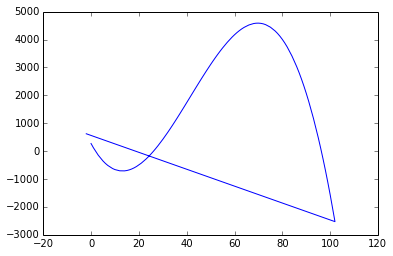

Year 2011, 4 degree polynomial regression
Train R2 0.595992
Test R2 0.669122


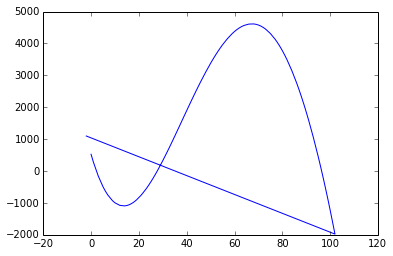

Year 2011, 5 degree polynomial regression
Train R2 0.733340
Test R2 0.744476


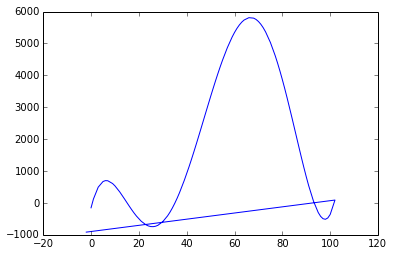

Year 2011, 6 degree polynomial regression
Train R2 0.757268
Test R2 0.767005


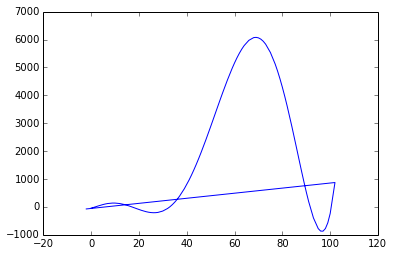

Year 2011, 7 degree polynomial regression
Train R2 0.763336
Test R2 0.768674


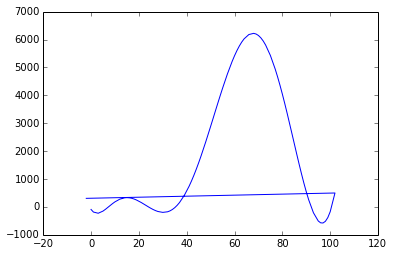

Year 2011, 8 degree polynomial regression
Train R2 0.771959
Test R2 0.773583


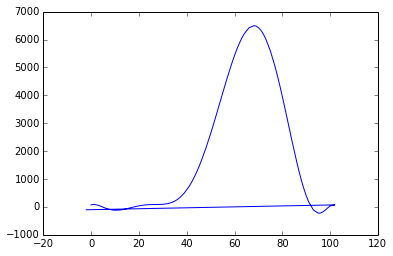

Year 2011, 9 degree polynomial regression
Train R2 0.772549
Test R2 0.772916


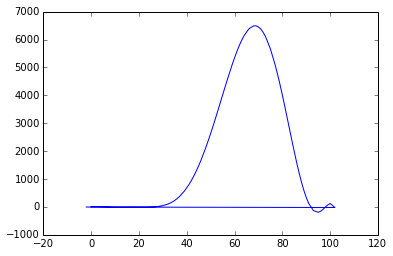

Year 2011, 10 degree polynomial regression
Train R2 0.774077
Test R2 0.770832


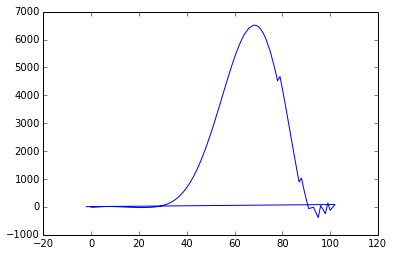

Year 2012, 3 degree polynomial regression
Train R2 0.751306
Test R2 0.685570


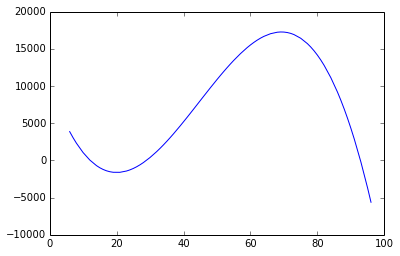

Year 2012, 4 degree polynomial regression
Train R2 0.751683
Test R2 0.684146


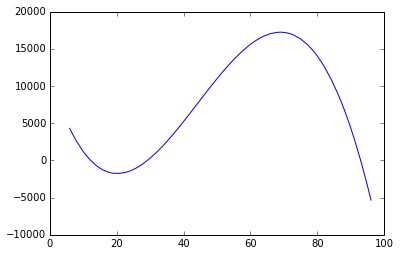

Year 2012, 5 degree polynomial regression
Train R2 0.799033
Test R2 0.730890


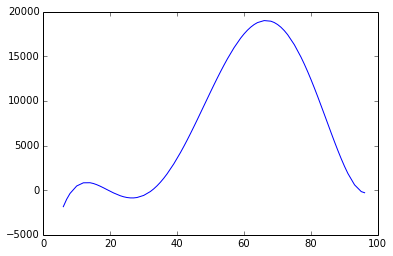

Year 2012, 6 degree polynomial regression
Train R2 0.806074
Test R2 0.742758


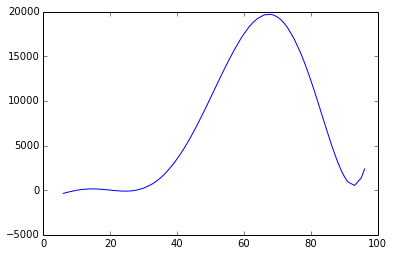

Year 2012, 7 degree polynomial regression
Train R2 0.806461
Test R2 0.741099


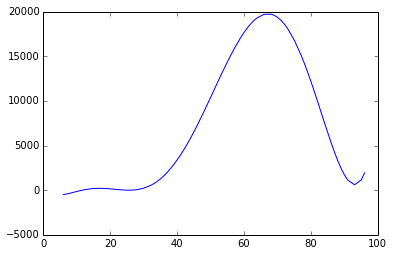

Year 2012, 8 degree polynomial regression
Train R2 0.807822
Test R2 0.738861


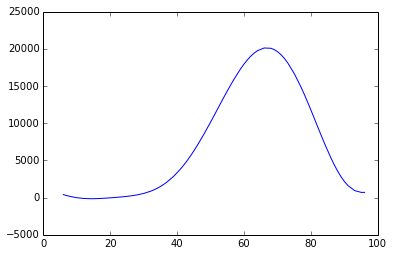

Year 2012, 9 degree polynomial regression
Train R2 0.807873
Test R2 0.739718


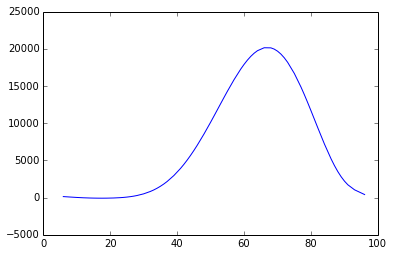

Year 2012, 10 degree polynomial regression
Train R2 0.809465
Test R2 0.730954


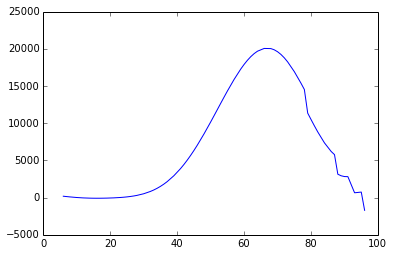

Year 2013, 3 degree polynomial regression
Train R2 0.763612
Test R2 0.575997


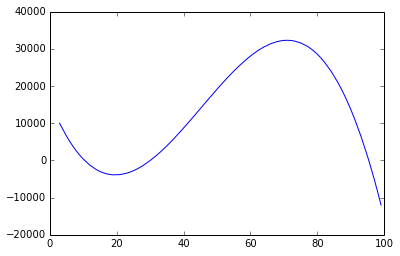

Year 2013, 4 degree polynomial regression
Train R2 0.782964
Test R2 0.392811


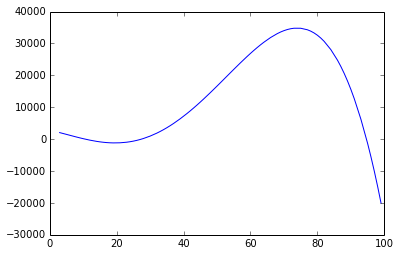

Year 2013, 5 degree polynomial regression
Train R2 0.802308
Test R2 0.646538


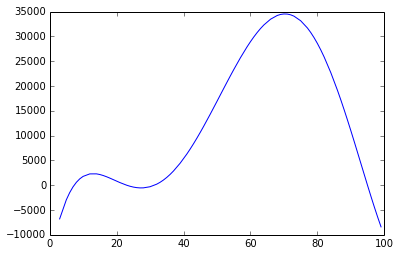

Year 2013, 6 degree polynomial regression
Train R2 0.821227
Test R2 0.702920


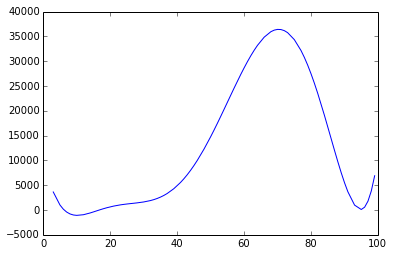

Year 2013, 7 degree polynomial regression
Train R2 0.826688
Test R2 0.592160


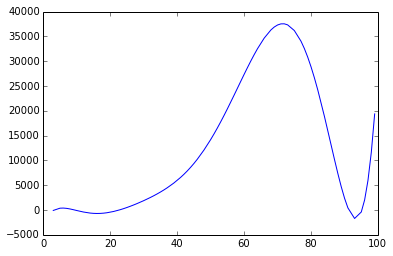

Year 2013, 8 degree polynomial regression
Train R2 0.827366
Test R2 0.487843


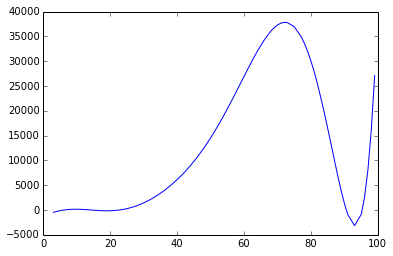

Year 2013, 9 degree polynomial regression
Train R2 0.827676
Test R2 0.573668


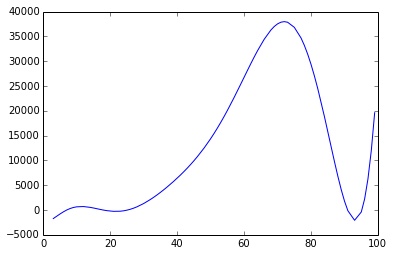

Year 2013, 10 degree polynomial regression
Train R2 0.828006
Test R2 0.510031


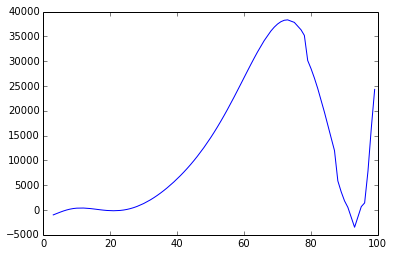

In [38]:
def lin_reg(year):
    
    # import temperature and ridership data
    temperatures, ridership = process_data(year)
    
    # turn data into array
    temps = np.array(temperatures)
    rides = np.array(ridership)

    # make array vertical so that scikit-learn can process it
    temps = temps.reshape(temps.shape[0], -1)
    rides = rides.reshape(rides.shape[0], -1)
    
    X_train, X_test, y_train, y_test = train_test_split(temps, rides, train_size=0.5)
    
    for degrees in range(3, 11):
        model = make_pipeline(PolynomialFeatures(degrees), Ridge())

        model.fit(X_train, y_train)
        print "Year %d, %d degree polynomial regression" % (year, degrees)
        print "Train R2 %f"%model.score(X_train, y_train)
        print "Test R2 %f"%model.score(X_test, y_test)

        y_plot = model.predict(temps)
        plt.plot(temps, y_plot)
        plt.show()

lin_reg(2011)
lin_reg(2012)
lin_reg(2013)